## Deface library test

In [ ]:
!deface data/crowd3.mp4

## Setup Deface env

In [6]:
from deface.deface import anonymize_frame, CenterFace

In [7]:
cd deface/deface/deface

[WinError 3] The system cannot find the path specified: 'deface/deface/deface'
D:\models\20.CSRNet\deface\deface\deface


D:\Programs\anaconda3\envs\crowd311\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


## Image/Video test

In [8]:
!python deface.py OIP.jpg

Running on AzureExecutionProvider.
Input:  OIP.jpg
Output: OIP_anonymized.jpg


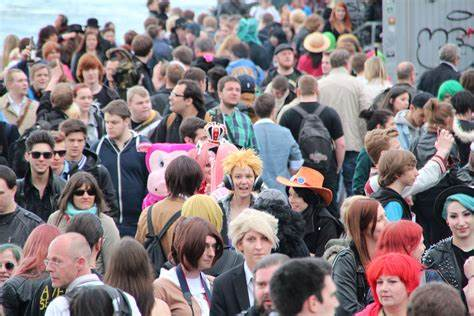

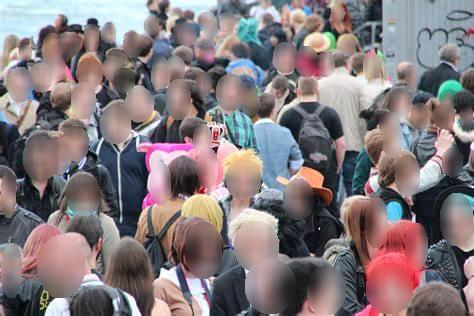

In [9]:
from IPython.display import Image, display

listOfImageNames = ['OIP.jpg','OIP_anonymized.jpg']
for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [ ]:
!python deface.py person720.mp4

In [ ]:
!python deface.py crowd3.mp4

## Stream test

In [13]:
import cv2
def display_anonymized_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Get the frames per second (fps) of the video
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create a CenterFace instance for face detection
    centerface = CenterFace(in_shape=None, backend='auto')

    # Create a window to display the video
    cv2.namedWindow("Anonymized Stream", cv2.WINDOW_NORMAL)

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Perform network inference, get bb dets but discard landmark predictions
        dets, _ = centerface(frame, threshold=0.2)

        # Anonymize the frame using the deface.py functions
        anonymize_frame(
            dets, frame, mask_scale=1.3,
            replacewith='blur', ellipse=True, draw_scores=False,
            replaceimg=None, mosaicsize=20)

        # Display the frame in the window
        cv2.imshow("Anonymized Stream", frame)

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    # Specify the path to the anonymized video created by deface.py
    video_path = "walk.mp4"

    # Call the function to display the anonymized video
    display_anonymized_video(video_path)

Running on AzureExecutionProvider.


In [ ]:
import cv2
from threading import Thread

class AnonymizedVideoDisplay:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.fps = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.centerface = CenterFace(in_shape=None, backend='auto')
        self.anonymizer = Thread(target=self.anonymize_frames, daemon=True)
        self.anonymizer.start()

    def anonymize_frames(self):
        while True:
            ret, frame = self.cap.read()

            if not ret:
                break

            dets, _ = self.centerface(frame, threshold=0.2)

            anonymize_frame(
                dets, frame, mask_scale=1.3,
                replacewith='blur', ellipse=True, draw_scores=False,
                replaceimg=None, mosaicsize=20)

            cv2.imshow("Anonymized Stream", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    def run(self):
        self.anonymizer.join()
        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "walk.mp4"
    anonymized_display = AnonymizedVideoDisplay(video_path)
    anonymized_display.run()

## Rtsp

In [21]:
import cv2

class AnonymizedVideoDisplay:
    def __init__(self, rtsp_url):
        self.rtsp_url = rtsp_url
        self.cap = cv2.VideoCapture(rtsp_url)
        self.stopped = False  # Flag to indicate whether to stop the stream

    def anonymize_frames(self, frame):
        # Add your frame anonymization logic here
        return frame  # For now, returning the same frame

    def run(self):
        while not self.stopped:
            ret, frame = self.cap.read()
            if not ret:
                print("Error reading frame")
                break

            frame = self.anonymize_frames(frame)
            cv2.imshow("Anonymized Stream", frame)

            # Check for key press 'q' to stop the stream
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                self.stopped = True

        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "rtsp://192.168.0.38:554/live"
    anonymized_display = AnonymizedVideoDisplay(video_path)
    anonymized_display.run()


In [ ]:
import cv2
from threading import Thread
import queue

class AnonymizedVideoDisplay:
    def __init__(self, rtsp_url):
        self.rtsp_url = rtsp_url
        self.cap = cv2.VideoCapture(rtsp_url)
        self.fps = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.frame_queue = queue.Queue()
        self.anonymizer = Thread(target=self.anonymize_frames, daemon=True)
        self.anonymizer.start()

    def anonymize_frames(self):
        global stop_worker
        while not stop_worker:
            if not self.frame_queue.empty():
                frame = self.frame_queue.get()
                dets, _ = self.centerface(frame, threshold=0.2)
                anonymize_frame(
                    dets, frame, mask_scale=1.3,
                    replacewith='blur', ellipse=True, draw_scores=False,
                    replaceimg=None, mosaicsize=20
                )
                cv2.imshow("Anonymized Stream", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    stop_worker = True
                    break

    def run(self):
        global stop_worker
        self.centerface = CenterFace(in_shape=None, backend='auto')
        while True:
            ret, frame = self.cap.read()

            if not ret:
                print("Error reading frame")
                stop_worker = True
                break

            self.frame_queue.put(frame)

        # Wait for the worker thread to finish
        self.anonymizer.join()

        # Release resources
        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    stop_worker = False
    video_path = "rtsp://192.168.0.38:554/live"
    anonymized_display = AnonymizedVideoDisplay(video_path)
    anonymized_display.run()


In [ ]:
import cv2
from threading import Thread
import queue

class AnonymizedVideoDisplay:
    def __init__(self, rtsp_url):
        self.rtsp_url = rtsp_url
        self.cap = cv2.VideoCapture(rtsp_url)
        self.fps = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.frame_queue = queue.Queue()
        self.anonymizer = Thread(target=self.anonymize_frames, daemon=True)
        self.anonymizer.start()

    def anonymize_frames(self):
        global stop_worker
        while not stop_worker:
            if not self.frame_queue.empty():
                frame = self.frame_queue.get()
                dets, _ = self.centerface(frame, threshold=0.2)
                anonymize_frame(
                    dets, frame, mask_scale=1.3,
                    replacewith='blur', ellipse=True, draw_scores=False,
                    replaceimg=None, mosaicsize=20)
                cv2.imshow("Anonymized Stream", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    stop_worker = True
                    break

    def run(self):
        global stop_worker
        self.centerface = CenterFace(in_shape=None, backend='auto')
        skip_frames = 10  # Adjust as needed
        frame_count = 0
        while True:
            ret, frame = self.cap.read()

            if not ret:
                print("Error reading frame")
                stop_worker = True
                break

            frame_count += 1

            if frame_count % skip_frames == 0:
                self.frame_queue.put(frame)

        # Wait for the worker thread to finish
        self.anonymizer.join()

        # Release resources
        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    stop_worker = False
    video_path = "rtsp://192.168.0.38:554/live"
    anonymized_display = AnonymizedVideoDisplay(video_path)
    anonymized_display.run()

In [ ]:
import cv2

class AnonymizedVideoDisplay:
    def __init__(self, rtsp_url):
        self.rtsp_url = rtsp_url
        self.cap = cv2.VideoCapture(rtsp_url)
        self.stopped = False  # Flag to indicate whether to stop the stream
        self.centerface = CenterFace(in_shape=None, backend='auto')

    def anonymize_frames(self, frame):
        # Perform network inference, get bounding box detections but discard landmark predictions
        dets, _ = self.centerface(frame, threshold=0.2)

        # Anonymize the frame using the deface.py functions
        anonymize_frame(
            dets, frame, mask_scale=1.3,
            replacewith='blur', ellipse=True, draw_scores=False,
            replaceimg=None, mosaicsize=20)

        return frame

    def run(self):
        while not self.stopped:
            ret, frame = self.cap.read()
            if not ret:
                print("Error reading frame")
                break

            frame = self.anonymize_frames(frame)
            cv2.imshow("Anonymized Stream", frame)

            # Check for key press 'q' to stop the stream
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                self.stopped = True

        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "rtsp://192.168.0.38:554/live"
    anonymized_display = AnonymizedVideoDisplay(video_path)
    anonymized_display.run()

In [22]:
import cv2

class AnonymizedVideoDisplay:
    def __init__(self, rtsp_url, skip_frames=0):
        self.rtsp_url = rtsp_url
        self.cap = cv2.VideoCapture(rtsp_url)
        self.stopped = False  # Flag to indicate whether to stop the stream
        self.centerface = CenterFace(in_shape=None, backend='auto')
        self.skip_frames = skip_frames
        self.frame_count = 0

    def anonymize_frames(self, frame):
        # Perform network inference, get bounding box detections but discard landmark predictions
        dets, _ = self.centerface(frame, threshold=0.2)

        # Anonymize the frame using the deface.py functions
        anonymize_frame(
            dets, frame, mask_scale=1.3,
            replacewith='blur', ellipse=True, draw_scores=False,
            replaceimg=None, mosaicsize=20)

        return frame

    def run(self):
        while not self.stopped:
            ret, frame = self.cap.read()
            if not ret:
                print("Error reading frame")
                break

            if self.frame_count % (self.skip_frames + 1) == 0:
                frame = self.anonymize_frames(frame)
                cv2.imshow("Anonymized Stream", frame)

            self.frame_count += 1

            # Check for key press 'q' to stop the stream
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                self.stopped = True

        self.cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    video_path = "rtsp://192.168.0.38:554/live"
    skip_frames = 10  # Adjust as needed
    anonymized_display = AnonymizedVideoDisplay(video_path, skip_frames)
    anonymized_display.run()


Running on AzureExecutionProvider.
